In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_curve, auc, roc_auc_score
import lightgbm as lgb

import gc

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load Data

file_name = "./data/train_preprocessed2.csv"
train_df = pd.read_csv(file_name, low_memory = False)

train_df.head()

,A..papers,A.papers,B.papers,C.papers,Dif.countries,Perc_non_australian,Number.people,PHD,Max.years.univ,Grants.succ,...,SEO.11,SEO.12,SEO.13,SEO.14,SEO.15,SEO.16,SEO.17,SEO.18,SEO.19,Grant.Status
0,4.0,2.0,0.0,0.0,1,0.00,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,6.0,12.0,2.0,2.0,1,1.00,1,1.0,20.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,7.0,20.0,20.0,7.0,2,0.75,4,2.0,50.0,0.0,...,0,0,2,0,0,0,0,0,0,1
3,0.0,3.0,13.0,3.0,1,1.00,2,2.0,15.0,0.0,...,0,0,2,0,0,0,0,0,0,1
4,3.0,0.0,1.0,0.0,1,0.00,1,1.0,10.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [3]:
#Setup data : Divide Test and Train set

array = train_df.values

data = array[:, 0:70]
target = array[:, 70]

data, target

seed = 7
test_size = 0.2

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = test_size, random_state = seed)


In [9]:
min_child_weightP = np.zeros(100)
max_depthP = np.zeros(100)
gammaP = np.zeros(100)
subsampleP = np.zeros(100)
colsample_bytreeP = np.zeros(100)
aucP = np.zeros(100)
cnt = 0

In [10]:
# XGB model Function using KFold 

def XGB_Train_Model_using_KFold(min_child_weight, max_depth, gamma, subsample,  colsample_bytree) : 
    xgb_params = {
        'n_trees' : 20,
        'eta' : 0.3,
        'max_depth' : int(max_depth),
        'subsample' : max(min(subsample, 1), 0),
        'objective' : 'reg:linear', 
        'eval_metric' : 'auc',
        'silent' : 1,
        'min_child_weight' : int(min_child_weight),
        'gamma' : max(gamma, 0), 
        'colsample_bytree' : max(min(colsample_bytree, 1), 0)
    }
    
    model = xgb.XGBClassifier(**xgb_params)
    
    kfold = KFold(n_splits = 5, random_state = 7, shuffle = True)
    results = cross_val_score(model, data, target, cv = kfold)
    auc = results.mean()*100
    print("AUC : %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    
    global min_child_weightP 
    global max_depthP 
    global gammaP 
    global subsampleP
    global colsample_bytreeP
    global aucP
    global cnt
    
    min_child_weightP[cnt] = min_child_weight
    max_depthP[cnt] = max_depth
    gammaP[cnt] = gamma
    subsampleP[cnt] = subsample
    colsample_bytreeP[cnt] = colsample_bytree
    aucP[cnt] = auc
    cnt += 1
    
    return auc

In [11]:
xgb_params = {
    
    #Learning Rate  -> not needed, doesn't change result in range (0.01, 0.2)
    #'eta' : (0.01, 0.2),
    
    #Minimum sum of weights : to control overfitting
    'min_child_weight' : (1, 20), 
    
    #Maximum depth of a tree : to control overfitting
    'max_depth' : (2, 10),
    
    #minimum loss reduction required to make a split : makes algorithm conservative
    'gamma' : (0, 10), 
    
    #max_delta_step is not needed since data is not imbalanced
    #'max_delta_step' : (0, 10),
    
    #Fraction of observations to be randomly samples for each tree
    #Lower: prevent overfitting
    'subsample' : (0.5, 1),
    
    #Fraction of columns to be randomly samples for each tree
    'colsample_bytree' : (0.1, 1),
    
    #colsamble_bylevel is not needed since subsample and colsample_bytree will do the job
    #'colsample_bylevel' = (0.1, 1),
    
    #L2 regularization term on weights
    #'lambda' = (?, ?)
    
    #L1 regularization term on weight
    #'alpha' = (?, ?)
    
    #scale_pos_weight is not needed since data is not imbalanced
    #'scale_pos_weight' = (0, 10)
    #'n_splits_param' : (5, 10)
}


xgb_bayesOPT = BayesianOptimization(XGB_Train_Model_using_KFold, xgb_params)
xgb_bayesOPT.maximize(init_points = 5, n_iter = 100)


Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
AUC : 86.62% (0.93%)
    1 | 00m02s |   86.62159 |             0.3229 |    8.4683 |      5.2444 |             9.7470 |      0.8759 | 
AUC : 87.63% (0.66%)
    2 | 00m01s |   87.63209 |             0.2108 |    4.2410 |      5.0896 |            18.8483 |      0.9460 | 
AUC : 87.21% (1.11%)
    3 | 00m01s |   87.20736 |             0.1162 |    2.1121 |      6.2926 |            18.6945 |      0.8682 | 
AUC : 85.36% (1.09%)
    4 | 00m03s |   85.35839 |             0.7214 |    9.7340 |      3.1833 |             1.3348 |      0.7499 | 
AUC : 86.72% (1.15%)
    5 | 00m01s |   86.72494 |             0.3223 |    5.2298 |      3.6934 |             2.3869 |      0.6313 | 
Bayesian Optimization
--------------------------------------------------------------------

AUC : 88.56% (0.69%)
   56 | 00m11s |   88.56232 |             0.1716 |    0.4375 |      5.5208 |            17.3614 |      0.6178 | 
AUC : 88.01% (0.92%)
   57 | 00m15s |   88.01109 |             0.5649 |    2.5892 |      6.0311 |            18.4945 |      0.7232 | 
AUC : 89.43% (0.68%)
   58 | 00m12s |   89.43497 |             0.3849 |    0.3000 |      6.2609 |            17.2998 |      0.5209 | 
AUC : 87.32% (1.02%)
   59 | 00m13s |   87.32205 |             0.9454 |    2.0781 |      4.3821 |            19.1470 |      1.0000 | 
AUC : 89.16% (0.64%)
   60 | 00m12s |   89.15944 |             0.3473 |    0.5386 |      6.0686 |            17.1838 |      0.5723 | 
AUC : 88.49% (0.97%)
   61 | 00m10s |   88.49343 |             0.1518 |    0.1257 |      6.0289 |            16.8065 |      0.5000 | 
AUC : 88.88% (0.85%)
   62 | 00m12s |   88.88384 |             0.6024 |    0.7265 |      5.1872 |            17.4827 |      1.0000 | 
AUC : 86.89% (0.87%)
   63 | 00m12s |   86.88571 |            

IndexError: index 100 is out of bounds for axis 0 with size 100

In [11]:
aucP = aucP/ 100

array([0.85347501, 0.82040693, 0.84474849, 0.85014544, 0.82465499,
       0.82923792, 0.84865304, 0.85198083, 0.83923686, 0.83532552,
       0.84337056, 0.84325628, 0.85186661, 0.83234631, 0.84061564,
       0.83670285, 0.84647045, 0.83682208, 0.84819294, 0.85232612,
       0.83935259, 0.84876706, 0.84899839, 0.84819412, 0.853476  ,
       0.84302534, 0.82706766, 0.85244198, 0.8477335 , 0.85209788])

In [12]:
'''
'min_child_weight' : (1, 20), 
'max_depth' : (2, 10),
'gamma' : (0, 10), 
'subsample' : (0.5, 1),
'colsample_bytree' : (0.1, 1),
    
''' 


"\n'min_child_weight' : (1, 20), \n'max_depth' : (2, 10),\n'gamma' : (0, 10), \n'subsample' : (0.5, 1),\n'colsample_bytree' : (0.1, 1),\n    \n"

In [14]:
import math 
stepSize = np.zeros(100)

for i in range (1, 100) : 
    diff1 = min_child_weightP[i] - min_child_weightP[i-1]
    diff2 = max_depthP[i] - max_depthP[i-1]
    diff3 = gammaP[i] - gammaP[i-1]
    diff4 = subsampleP[i] - subsampleP[i-1]
    diff5 = colsample_bytreeP[i] - colsample_bytreeP[i-1]
    stepSize[i] = math.sqrt((diff1 * diff1) + (diff2 * diff2) + (diff3 * diff3) + (diff4 * diff4) + (diff5 * diff5))
    

"\nfig, ax1 = plt.subplots(figsize = (20,10))\n\nax1.plot( 'step', 'stepSize', data=df, marker='o', color='blue', linewidth=2, label = 'stepSize')\n\nfig.tight_layout()\n\nplt.show()\n"

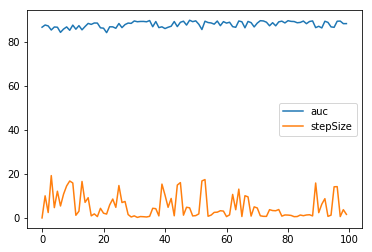

In [19]:
import matplotlib.pyplot as plt
df = pd.DataFrame({'step' : np.arange(100), 'stepSize' : stepSize, 'auc' : aucP})
df.plot()

fig, ax1 = plt.subplots(figsize = (20,10))

ax1.plot( 'step', 'stepSize', data=df, marker='o', color='blue', linewidth=2, label = 'stepSize')
ax2 = ax1.twinx()
ax2.plot('step', 'auc', data = df, marker = )
fig.tight_layout()

plt.show()
'''

In [20]:
df

,auc,stepSize
0,86.621589,0.000000
1,87.632093,10.037165
2,87.207360,2.453138
3,85.358389,19.222382
4,86.724938,4.672011
5,86.621543,12.125209
6,84.290651,5.422565
7,85.783267,10.791973
8,86.770856,14.536226
9,85.232031,16.768261
